In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Goal: PREDICT THE NUMBERS FOR EACH COUNTRIES REFUGEES

In [ ]:
data= pd.read_csv('./data/UNdata_Export_20170204_232027222.csv',parse_dates=['Year'])

In [ ]:
data.columns

In [ ]:
data.columns  = [u'Country or territory of asylum or residence',
       u'Country or territory of origin', u'Year', u'Refugees',
       u'Refugees assisted by UNHCR',
       u'Total refugees and people in refugee-like situations',
       u'Total refugees and people in refugee-like situations assisted by UNHCR']

In [ ]:
data['Year'] = data['Year'].apply(lambda x: x.year)

In [ ]:
# data['ratio of all refugees and those assisted by UNHCR'] = data['Total refugees and people in refugee-like situations']/data['Total refugees and people in refugee-like situations assisted by UNHCR']

In [ ]:
data = data.dropna()

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
plt.plot(data['Year'],data['Refugees assisted by UNHCR'],'r.',alpha =0.7)

In [ ]:
by_origin = data.groupby('Country or territory of origin').sum()
by_origin.head()

In [ ]:
by_origin.plot(kind='bar')

In [ ]:
by_asylum = data.groupby(u'Country or territory of asylum or residence').sum()
by_asylum.head()

In [ ]:
by_asylum.plot(kind='bar',figsize=(20,10))

In [ ]:
by_year = data.groupby(u'Year').sum()
by_year.plot()
by_year = by_year.reset_index()

In [ ]:
by_year.plot(kind ='hist')

### This actually shows some interesting trends, of course the data all follow the same basic curves, since they are all subgroups of Refugees. Already this data seems sparse.

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(data['Year'],data['Total refugees and people in refugee-like situations assisted by UNHCR'],'r.')

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(data['Year'],data['Total refugees and people in refugee-like situations'],'.')
plt.show()

#### No strong correlations with this kind of exploration, I'll end up looking at individual countries now.

# Looking at a single country over time

In [ ]:
def one_country(data,country):
    #for a single country get everything
    country_df = data[data['Country or territory of asylum or residence'] == country]
    return(country_df)

In [ ]:
afg_df = one_country(data,'Afghanistan')
afg_df.head()

In [ ]:
plt.plot(afg_df['Year'],afg_df['Refugees'],color = 'blue')
# plt.plot(afg_df['Year'],afg_df['Total refugees and people in refugee-like situations'],color = 'red')
plt.show()

# Looking at all countries, setting a maximum threshold to inspect the range of refugees

In [ ]:
def plot_all_countries(data,threshold):
    plt.figure(figsize=(20,10))
    countries = data['Country or territory of asylum or residence']
    countries = countries.unique()
    for i in countries:
        country = data[data['Country or territory of asylum or residence']==i]
        if max(country['Refugees'])<threshold:
            plt.plot(country['Year'],country['Refugees'],label = str(i).decode('utf-8'))
            plt.legend()
        else:
            break

In [ ]:
plot_all_countries(data,500000)

# Okay, maybe just do this: Starting with separating out the countries start looking at the projections for next year for both the origin and the relocated place. 

#### Trying Linear Regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
lr = LinearRegression()
X = by_year['Year']
y = by_year['Refugees']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)
lr.fit(X_train[:,np.newaxis], y_train)
y_predict= lr.predict(X_test[:,np.newaxis])
plt.plot(y_test,y_predict,'.')
plt.plot(np.linspace(0,10000000),np.linspace(0,10000000))
plt.xlim(0.6*10**7)
plt.ylim(0.6*10**7)
plt.show()

The issue is that I have like, no data points for each origin country this way. i'd have too many distinct places otherwise for each place. Each origin has 15 time series points. But the combination of the origin and place of asylum is richer. There is something to that...

In [ ]:
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot
lag_plot(by_year['Refugees'])
pyplot.show()

In [ ]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(by_year['Refugees'])

In [ ]:
by_year

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(by_year['Refugees'])
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(by_year['Refugees'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

# Autoregression Model

In [ ]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
series = by_year['Refugees']
# split dataset
X = series.values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
## Trying to figure out LSTMs

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = by_year[['Refugees']]
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),'k')
plt.plot(trainPredictPlot,'b')
plt.plot(testPredictPlot,'r')
plt.show()

## Trying time series analysis on more data

In [2]:
ls data/

unhcr_popstats_export_time_series_all_data.csv


In [ ]:
pd.to_numeric(data_2['Value'])

In [ ]:
data_2.shape

In [ ]:
data_2.describe()

In [4]:
data_2= pd.read_csv('./data/unhcr_popstats_export_time_series_all_data.csv',parse_dates=['Year'])
data_2['Year'] = data_2['Year'].apply(lambda x: x.year)
data_2.dropna(axis = 0,inplace = True)
def if_numeric(val):
    try:
        return(int(val))
    except:
        return(np.nan)
data_2['Value'] = data_2['Value'].apply(if_numeric)
data_2.head()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000.0
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000.0
2,1951,Belgium,Various/Unknown,Refugees (incl. refugee-like situations),55000.0
3,1951,Canada,Various/Unknown,Refugees (incl. refugee-like situations),168511.0
4,1951,Switzerland,Various/Unknown,Refugees (incl. refugee-like situations),10000.0


In [5]:
data_2

,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000.0
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000.0
2,1951,Belgium,Various/Unknown,Refugees (incl. refugee-like situations),55000.0
3,1951,Canada,Various/Unknown,Refugees (incl. refugee-like situations),168511.0
4,1951,Switzerland,Various/Unknown,Refugees (incl. refugee-like situations),10000.0
5,1951,Germany,Various/Unknown,Refugees (incl. refugee-like situations),265000.0
6,1951,Denmark,Various/Unknown,Refugees (incl. refugee-like situations),2000.0
7,1951,Spain,Various/Unknown,Refugees (incl. refugee-like situations),2000.0
8,1951,France,Various/Unknown,Refugees (incl. refugee-like situations),290000.0
9,1951,United Kingdom,Various/Unknown,Refugees (incl. refugee-like situations),208000.0


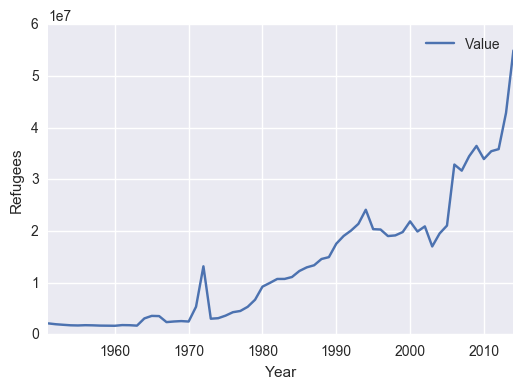

In [6]:
by_year = data_2.groupby(u'Year')['Value'].sum()
by_year = by_year.reset_index()
by_year.plot('Year','Value')
plt.ylabel('Refugees')

In [7]:
def plot_all_countries(data,threshold):
    plt.figure(figsize=(20,10))
    countries = data['Country / territory of asylum/residence']
    countries = countries.unique()
    for i in countries:
        country = data[data['Country / territory of asylum/residence']==i]
        if max(country['Value'])<threshold:
            plt.plot(country['Year'],country['Value'],label = str(i).decode('utf-8'))
            plt.legend()
        else:
            break

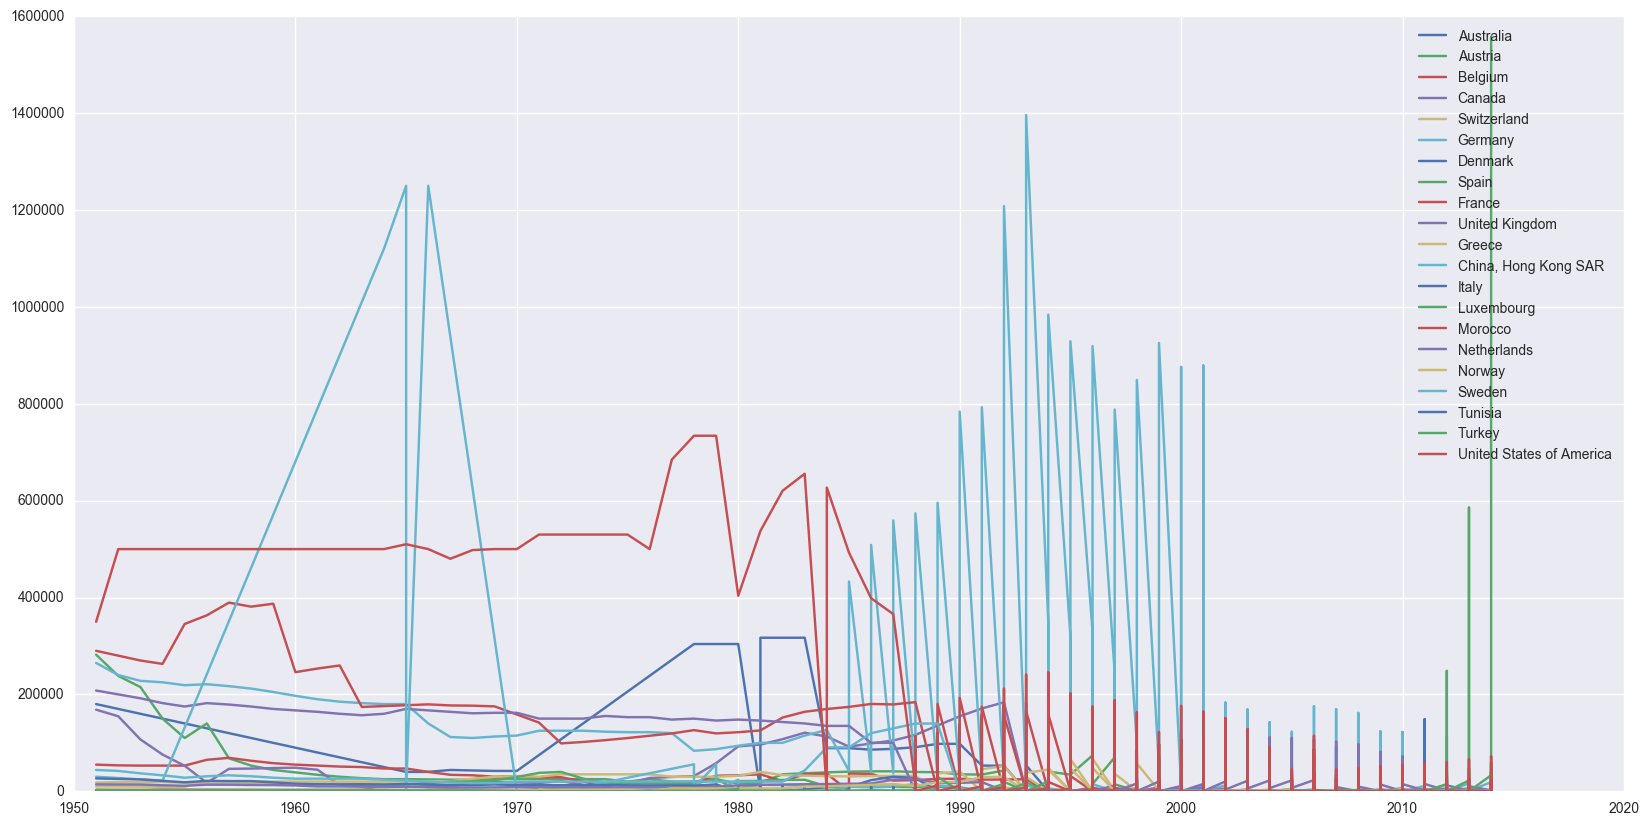

In [8]:
plot_all_countries(data_2,5000000)

# Autoregression model

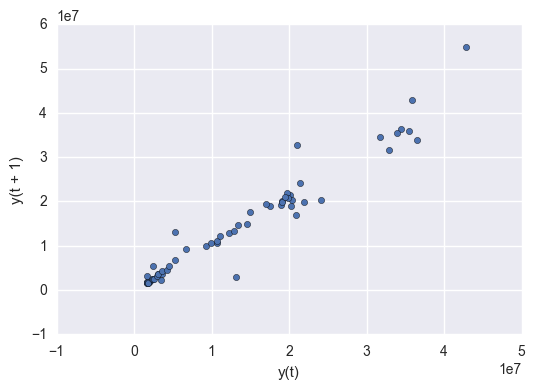

In [9]:
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot
lag_plot(by_year['Value'])
pyplot.show()

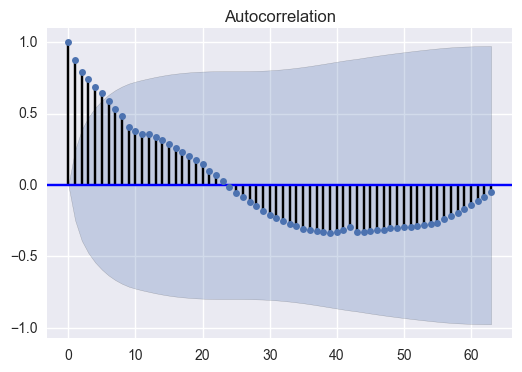

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(by_year['Value'])
plt.show()

Lag: 10
Coefficients: [  7.80253698e+05   7.88467909e-01   1.07212009e-01  -1.98773067e-01
   1.59625489e-01  -1.50151079e-01   3.61612598e-01  -1.45263055e-01
   1.75125540e-01  -2.21568452e-01   1.71913814e-01]
predicted=30405539.563075, expected=36466053.000000
predicted=31832923.588301, expected=33924438.000000
predicted=28958904.108646, expected=35441863.000000
predicted=33793842.647498, expected=35847933.000000
predicted=32849708.538150, expected=42865397.000000
predicted=37370777.136412, expected=54937556.000000
Test MSE: 82709672303959.703


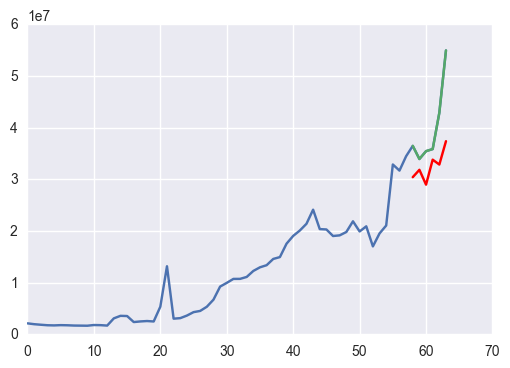

In [11]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
series = by_year['Value']
# split dataset
X = series.values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(range(len(X)),X)
plt.plot(range(len(X)-6,len(X)),test)
plt.plot(range(len(X)-6,len(X)),predictions, color='red')
plt.show()

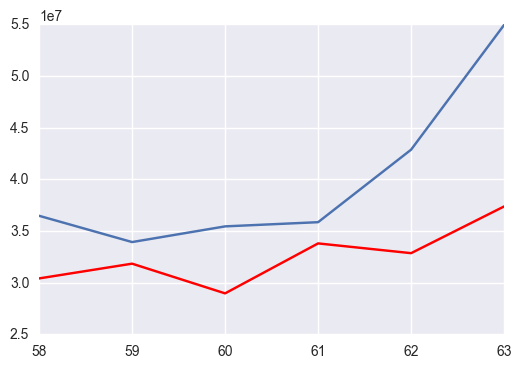

In [12]:
plt.plot(range(len(X)-6,len(X)),test)
plt.plot(range(len(X)-6,len(X)),predictions, color='red')
plt.show()

In [14]:
# plt.plot(scaler.inverse_transform(dataset),'k')
# plt.plot(trainPredictPlot,'b')
# plt.plot(testPredictPlot,'r')
# plt.show()

## trying an LSTM again

In [19]:
def lstm_time_series(data_set = by_year,col="Value"):
#     data_set.dropna(axis = 0,inplace =True)
    import numpy
    import matplotlib.pyplot as plt
    from pandas import read_csv
    import math
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    
    # convert an array of values into a dataset matrix
    
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return numpy.array(dataX), numpy.array(dataY)
    
    # fix random seed for reproducibility
    numpy.random.seed(7)
    # load the dataset
    
    dataframe = data_set[[col]]
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # reshape into X=t and Y=t+1
    look_back = 2
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    
    plt.plot(scaler.inverse_transform(dataset),'k')
    plt.plot(trainPredictPlot,'b')
    plt.plot(testPredictPlot,'r')
    plt.show()

In [ ]:
lstm_time_series(data_2,'Value')

Epoch 1/10


In [ ]:
def one_country(data,country):
    #for a single country get everything
    country_df = data[data['Country / territory of asylum/residence'] == country]
    plt.plot(country_df['Year'],country_df['Value'])
    return(country_df)

In [ ]:
afg_df = one_country(data_2,'Afghanistan')

In [ ]:
lstm_time_series(afg_df,'Value')